<a href="https://colab.research.google.com/github/ninja-marduk/ml_precipitation_prediction/blob/feature%2Fbase-models/models/base_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Configuración del entorno (compatible con Colab y local)
import os
import sys
from pathlib import Path
import shutil
import time
import psutil

# Regenerar el código con las condiciones específicas
notebook_globals = {
    "USE_CROSS_VALIDATION": False,
    "ENABLED_MODELS": ['CNN', 'GRU'],
    "ENABLED_EXPERIMENTS": ['time+cycles', 'all_features']
}

# Detectar si estamos en Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    # Si estamos en Colab, clonar el repositorio
    !git clone https://github.com/ninja-marduk/ml_precipitation_prediction.git
    %cd ml_precipitation_prediction
    # Instalar dependencias necesarias
    !pip install -r requirements.txt
    !pip install xarray netCDF4 optuna matplotlib seaborn lightgbm xgboost scikit-learn ace_tools_open cartopy
    BASE_PATH = '/content/drive/MyDrive/ml_precipitation_prediction'
else:
    # Si estamos en local, usar la ruta actual
    if '/models' in os.getcwd():
        BASE_PATH = Path('..')
    else:
        BASE_PATH = Path('.')

print(f"Entorno configurado. Usando ruta base: {BASE_PATH}")

# Si BASE_PATH viene como string, lo convertimos
BASE_PATH = Path(BASE_PATH)

# Ahora puedes concatenar correctamente
data_output_dir = BASE_PATH / 'data' / 'output'
model_output_dir = BASE_PATH / 'models' / 'output'


Mounted at /content/drive
Cloning into 'ml_precipitation_prediction'...
remote: Enumerating objects: 934, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 934 (delta 45), reused 6 (delta 6), pack-reused 863 (from 1)
Receiving objects: 100% (934/934), 100.45 MiB | 16.70 MiB/s, done.
Resolving deltas: 100% (513/513), done.
/content/ml_precipitation_prediction
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 116.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━

In [2]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Bidirectional, Reshape
import traceback

# ==== Variables de control ====
USE_CROSS_VALIDATION = False
ENABLED_MODELS = ['LSTM']
ENABLED_EXPERIMENTS = ['time+cycles+lag'] # 'time+cycles', 'time+cycles+elev', 'time+cycles+elev+cluster'
INPUT_WINDOW = 60
OUTPUT_HORIZON = 3

# ==== Funciones auxiliares ====
def build_model(model_type, input_shape, output_neurons, n_cells):
    model = Sequential()
    model.add(Input(shape=input_shape, dtype='float32'))  # ahora input_shape=(INPUT_WINDOW, n_cells*feats)
    if model_type == 'LSTM':
        model.add(LSTM(64))
    elif model_type == 'GRU':
        model.add(GRU(64))
    elif model_type == 'BLSTM':
        model.add(Bidirectional(LSTM(64)))
    # salida: OUTPUT_HORIZON pasos × n_cells celdas
    model.add(Dense(output_neurons * n_cells))
    model.add(Reshape((output_neurons, n_cells)))
    model.compile(optimizer='adam', loss='mse')
    return model

def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-5))) * 100
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, mape, r2

# ==== Directorios y Dataset ====
model_output_dir_STH = Path("/content/drive/MyDrive/ml_precipitation_prediction/models/output/ST_HybridWaveStack")
curves_dir = model_output_dir_STH / "learning_curves"
data_output_dir = Path("/content/drive/MyDrive/ml_precipitation_prediction/data/output")
file_path = data_output_dir / "complete_dataset_with_features_with_clusters_elevation_with_windows.nc"
model_output_dir_STH.mkdir(parents=True, exist_ok=True)
curves_dir.mkdir(parents=True, exist_ok=True)

print(f"✔️ Dataset cargado desde: {file_path}")
ds = xr.open_dataset(file_path)

# ==== Configuración de experimentos ====
experiment_settings = {
    "time+cycles": ['year','month',
                    'month_sin','month_cos','doy_sin','doy_cos'],
    "time+cycles+lag":  ['year','month',
                        'month_sin','month_cos','doy_sin','doy_cos',
                        'total_precipitation_lag1','total_precipitation_lag2','total_precipitation_lag3',
                        'total_precipitation_lag4','total_precipitation_lag12','total_precipitation_lag24','total_precipitation_lag36'],
    "time+cycles+lag+elev": ['year','month',
                             'month_sin','month_cos','doy_sin','doy_cos',
                            'total_precipitation_lag1','total_precipitation_lag2','total_precipitation_lag3',
                            'total_precipitation_lag4','total_precipitation_lag12','total_precipitation_lag24','total_precipitation_lag36',
                            'elevation','slope','aspect'],
    "time+cycles+elev":   ['year','month',
                          'month_sin','month_cos','doy_sin','doy_cos',
                          'elevation','slope','aspect'],
    "time+cycles+elev+cluster":   ['year','month',
                                  'month_sin','month_cos','doy_sin','doy_cos',
                                  'elevation','slope','aspect',
                                  'cluster_elevation'],
    "all_features": ['year','month',
                     'month_sin','month_cos','doy_sin','doy_cos',
                    'total_precipitation_lag1','total_precipitation_lag2','total_precipitation_lag3',
                    'total_precipitation_lag4','total_precipitation_lag12','total_precipitation_lag24','total_precipitation_lag36',
                    'elevation','slope','aspect',
                     'cluster_elevation']
}

results = []

for exp_name, variables in experiment_settings.items():
    if exp_name not in ENABLED_EXPERIMENTS:
        continue
    try:
        print(f"🔍 Procesando experimento: {exp_name}")
        # cargar y, si hay cluster, codificarlo
        subset = ds[variables].to_array().transpose('time','latitude','longitude','variable').values
        if 'cluster_elevation' in variables:
            idx = variables.index('cluster_elevation')
            flat = subset[..., idx].ravel()
            subset[..., idx] = LabelEncoder().fit_transform(flat).reshape(subset[..., idx].shape)
        subset = subset.astype(np.float32)
        target = ds['total_precipitation'].values

        samples, lat, lon, feats = subset.shape
        n_cells = lat * lon

        # [time, lat*lon, feats]
        X = subset.reshape(samples, n_cells, feats)
        y = target.reshape(samples, n_cells)

        # generar secuencias
        X_seq, Y_seq = [], []
        for i in range(samples - INPUT_WINDOW - OUTPUT_HORIZON):
            X_seq.append(X[i:i+INPUT_WINDOW])
            Y_seq.append(y[i+INPUT_WINDOW:i+INPUT_WINDOW+OUTPUT_HORIZON])
        X_seq = np.array(X_seq)   # (N, INPUT_WINDOW, n_cells, feats)
        Y_seq = np.array(Y_seq)   # (N, OUTPUT_HORIZON, n_cells)

        # *** Esta es la corrección clave: aplanar la dimensión de "feats" dentro de features ***
        N = X_seq.shape[0]
        X_seq = X_seq.reshape(N, INPUT_WINDOW, n_cells * feats)  # (N, INPUT_WINDOW, n_cells*feats)

        # filtrar secuencias con NaNs
        mask_X = ~np.isnan(X_seq).any(axis=(1,2))  # (N,)
        mask_Y = ~np.isnan(Y_seq).any(axis=(1,2))  # (N,)
        valid_mask = mask_X & mask_Y
        X_seq = X_seq[valid_mask]
        Y_seq = Y_seq[valid_mask]
        if len(X_seq)==0:
            print("⚠️ No quedan secuencias válidas tras filtrar NaNs.")
            continue

        # entrenar por modelo
        input_shape = (INPUT_WINDOW, n_cells * feats)
        split = int(len(X_seq)*0.7)
        X_tr, X_va = X_seq[:split], X_seq[split:]
        y_tr, y_va = Y_seq[:split], Y_seq[split:]

        # escalado
        scalerX = StandardScaler()
        X_tr = scalerX.fit_transform(X_tr.reshape(-1, input_shape[-1])).reshape(X_tr.shape)
        X_va = scalerX.transform  (X_va.reshape(-1, input_shape[-1])).reshape(X_va.shape)

        scalerY = StandardScaler()
        y_tr = scalerY.fit_transform(y_tr.reshape(-1,1)).reshape(y_tr.shape)
        y_va = scalerY.transform  (y_va.reshape(-1,1)).reshape(y_va.shape)

        for model_name in ENABLED_MODELS:
            model_path = model_output_dir_STH / f"{exp_name.replace('+','_')}_{model_name}_NoCV.h5"
            if model_path.exists():
                print(f"⏩ Ya existe: {model_path.name}")
                continue

            model = build_model(model_name, input_shape, OUTPUT_HORIZON, n_cells)
            es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            history = model.fit(
                X_tr, y_tr,
                validation_data=(X_va, y_va),
                epochs=100, batch_size=16, verbose=1,
                callbacks=[es]
            )

            y_pred = model.predict(X_va)
            # revertir escala
            y_pred = scalerY.inverse_transform(y_pred.reshape(-1,1)).reshape(y_pred.shape)
            y_true = scalerY.inverse_transform(y_va.reshape(-1,1)).reshape(y_va.shape)

            # evaluar
            metrics = [
                evaluate(y_true[:,i].ravel(), y_pred[:,i].ravel())
                for i in range(OUTPUT_HORIZON)
            ]
            results.append({
                'experiment': exp_name,
                'model': model_name,
                'horizon': OUTPUT_HORIZON,
                'RMSE': np.mean([m[0] for m in metrics]),
                'MAE':  np.mean([m[1] for m in metrics]),
                'MAPE': np.mean([m[2] for m in metrics]),
                'R2':   np.mean([m[3] for m in metrics]),
                'epochs': len(history.history['loss'])
            })

            # guardar curva
            plt.figure()
            plt.plot(history.history['loss'], label='Train')
            plt.plot(history.history['val_loss'], label='Val')
            plt.title(f"{exp_name} - {model_name}")
            plt.legend()
            plt.savefig(curves_dir / f"{exp_name.replace('+','_')}_{model_name}_NoCV.png")
            plt.close()

            model.save(model_path)
            print(f"✅ Guardado: {model_path.name}")

    except Exception as e:
        print(f"❌ Error en '{exp_name}': {e}\n{traceback.format_exc()}")

# resultados
results_df = pd.DataFrame(results)
results_df.to_csv("resultados_modelos_cv_fullmap.csv", index=False)
import ace_tools_open as tools
tools.display_dataframe_to_user(name="Resultados Modelos FullMap", dataframe=results_df)


✔️ Dataset cargado desde: /content/drive/MyDrive/ml_precipitation_prediction/data/output/complete_dataset_with_features_with_clusters_elevation_with_windows.nc
🔍 Procesando experimento: time+cycles+lag
Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 340ms/step - loss: 0.9242 - val_loss: 0.6121
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - loss: 0.5676 - val_loss: 0.4791
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 0.4035 - val_loss: 0.4381
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 0.3392 - val_loss: 0.4042
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 0.3084 - val_loss: 0.4096
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - loss: 0.2741 - val_loss: 0.3924
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 0.2518 - val_loss: 0.3606
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 0.2373 - val_loss: 0.3392
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - loss: 0.2317 - val_loss: 0.3435
Epoch 10/100
19

✅ Guardado: time_cycles_lag_LSTM_NoCV.h5
Resultados Modelos FullMap


📂 Cargando dataset y rellenando NaNs…

🔍 Evaluando modelo: time_cycles_LSTM_NoCV


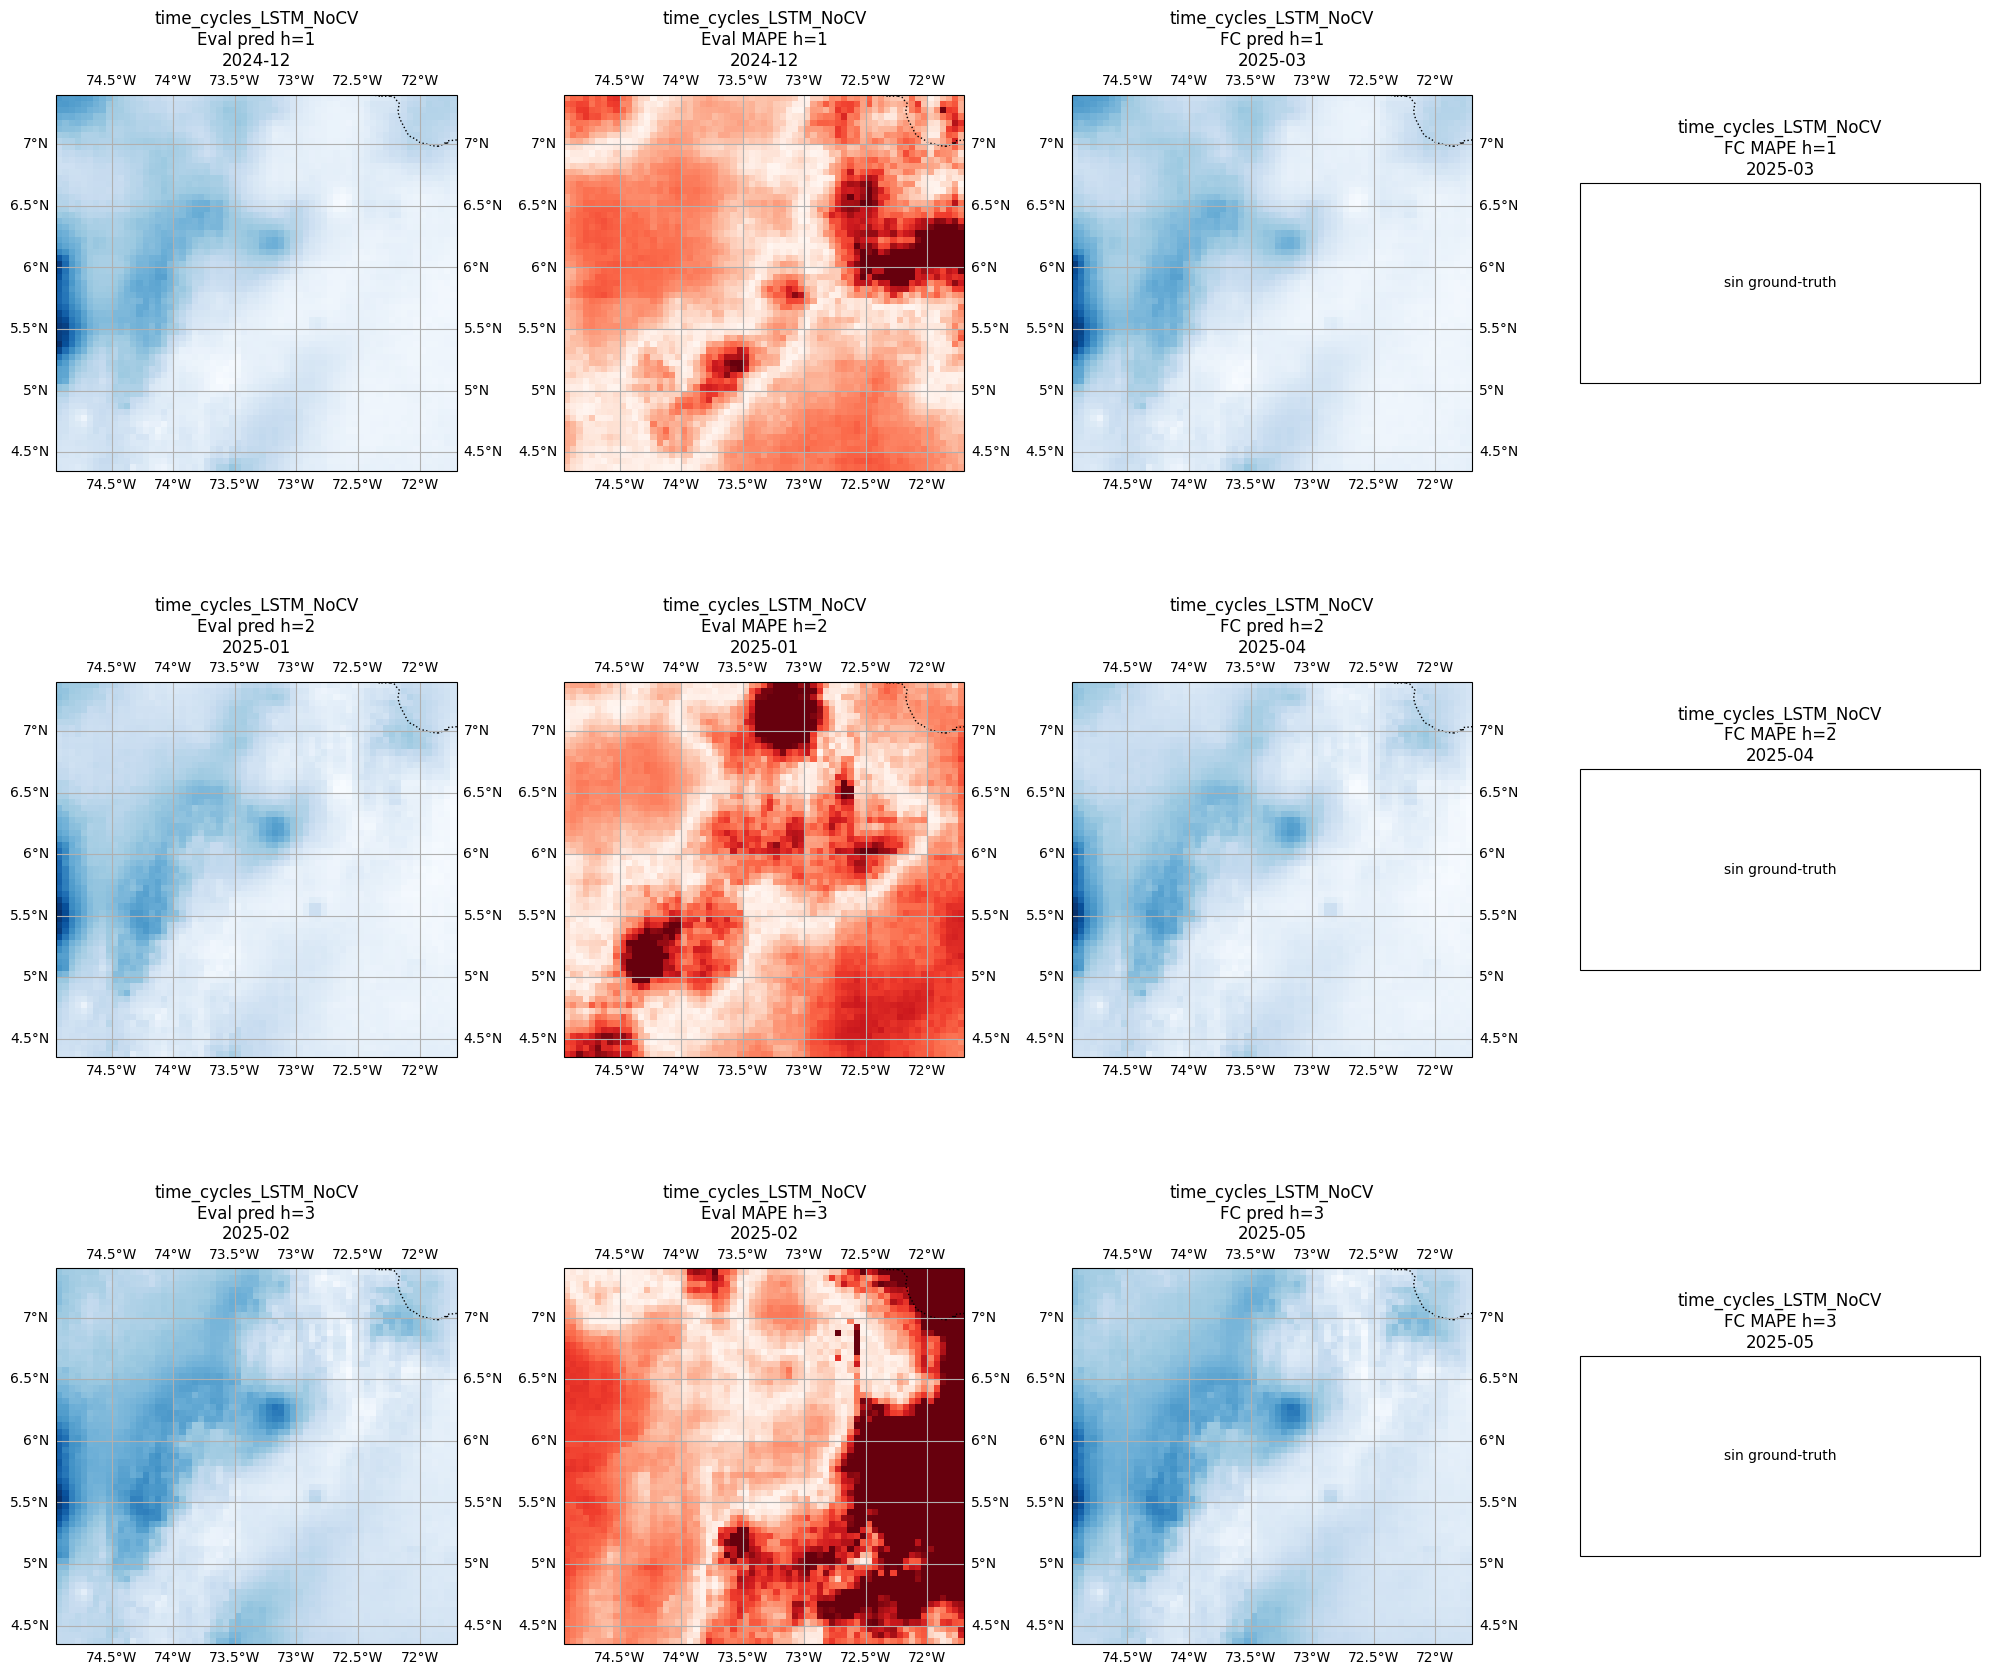


🔍 Evaluando modelo: time_cycles_elev_LSTM_NoCV


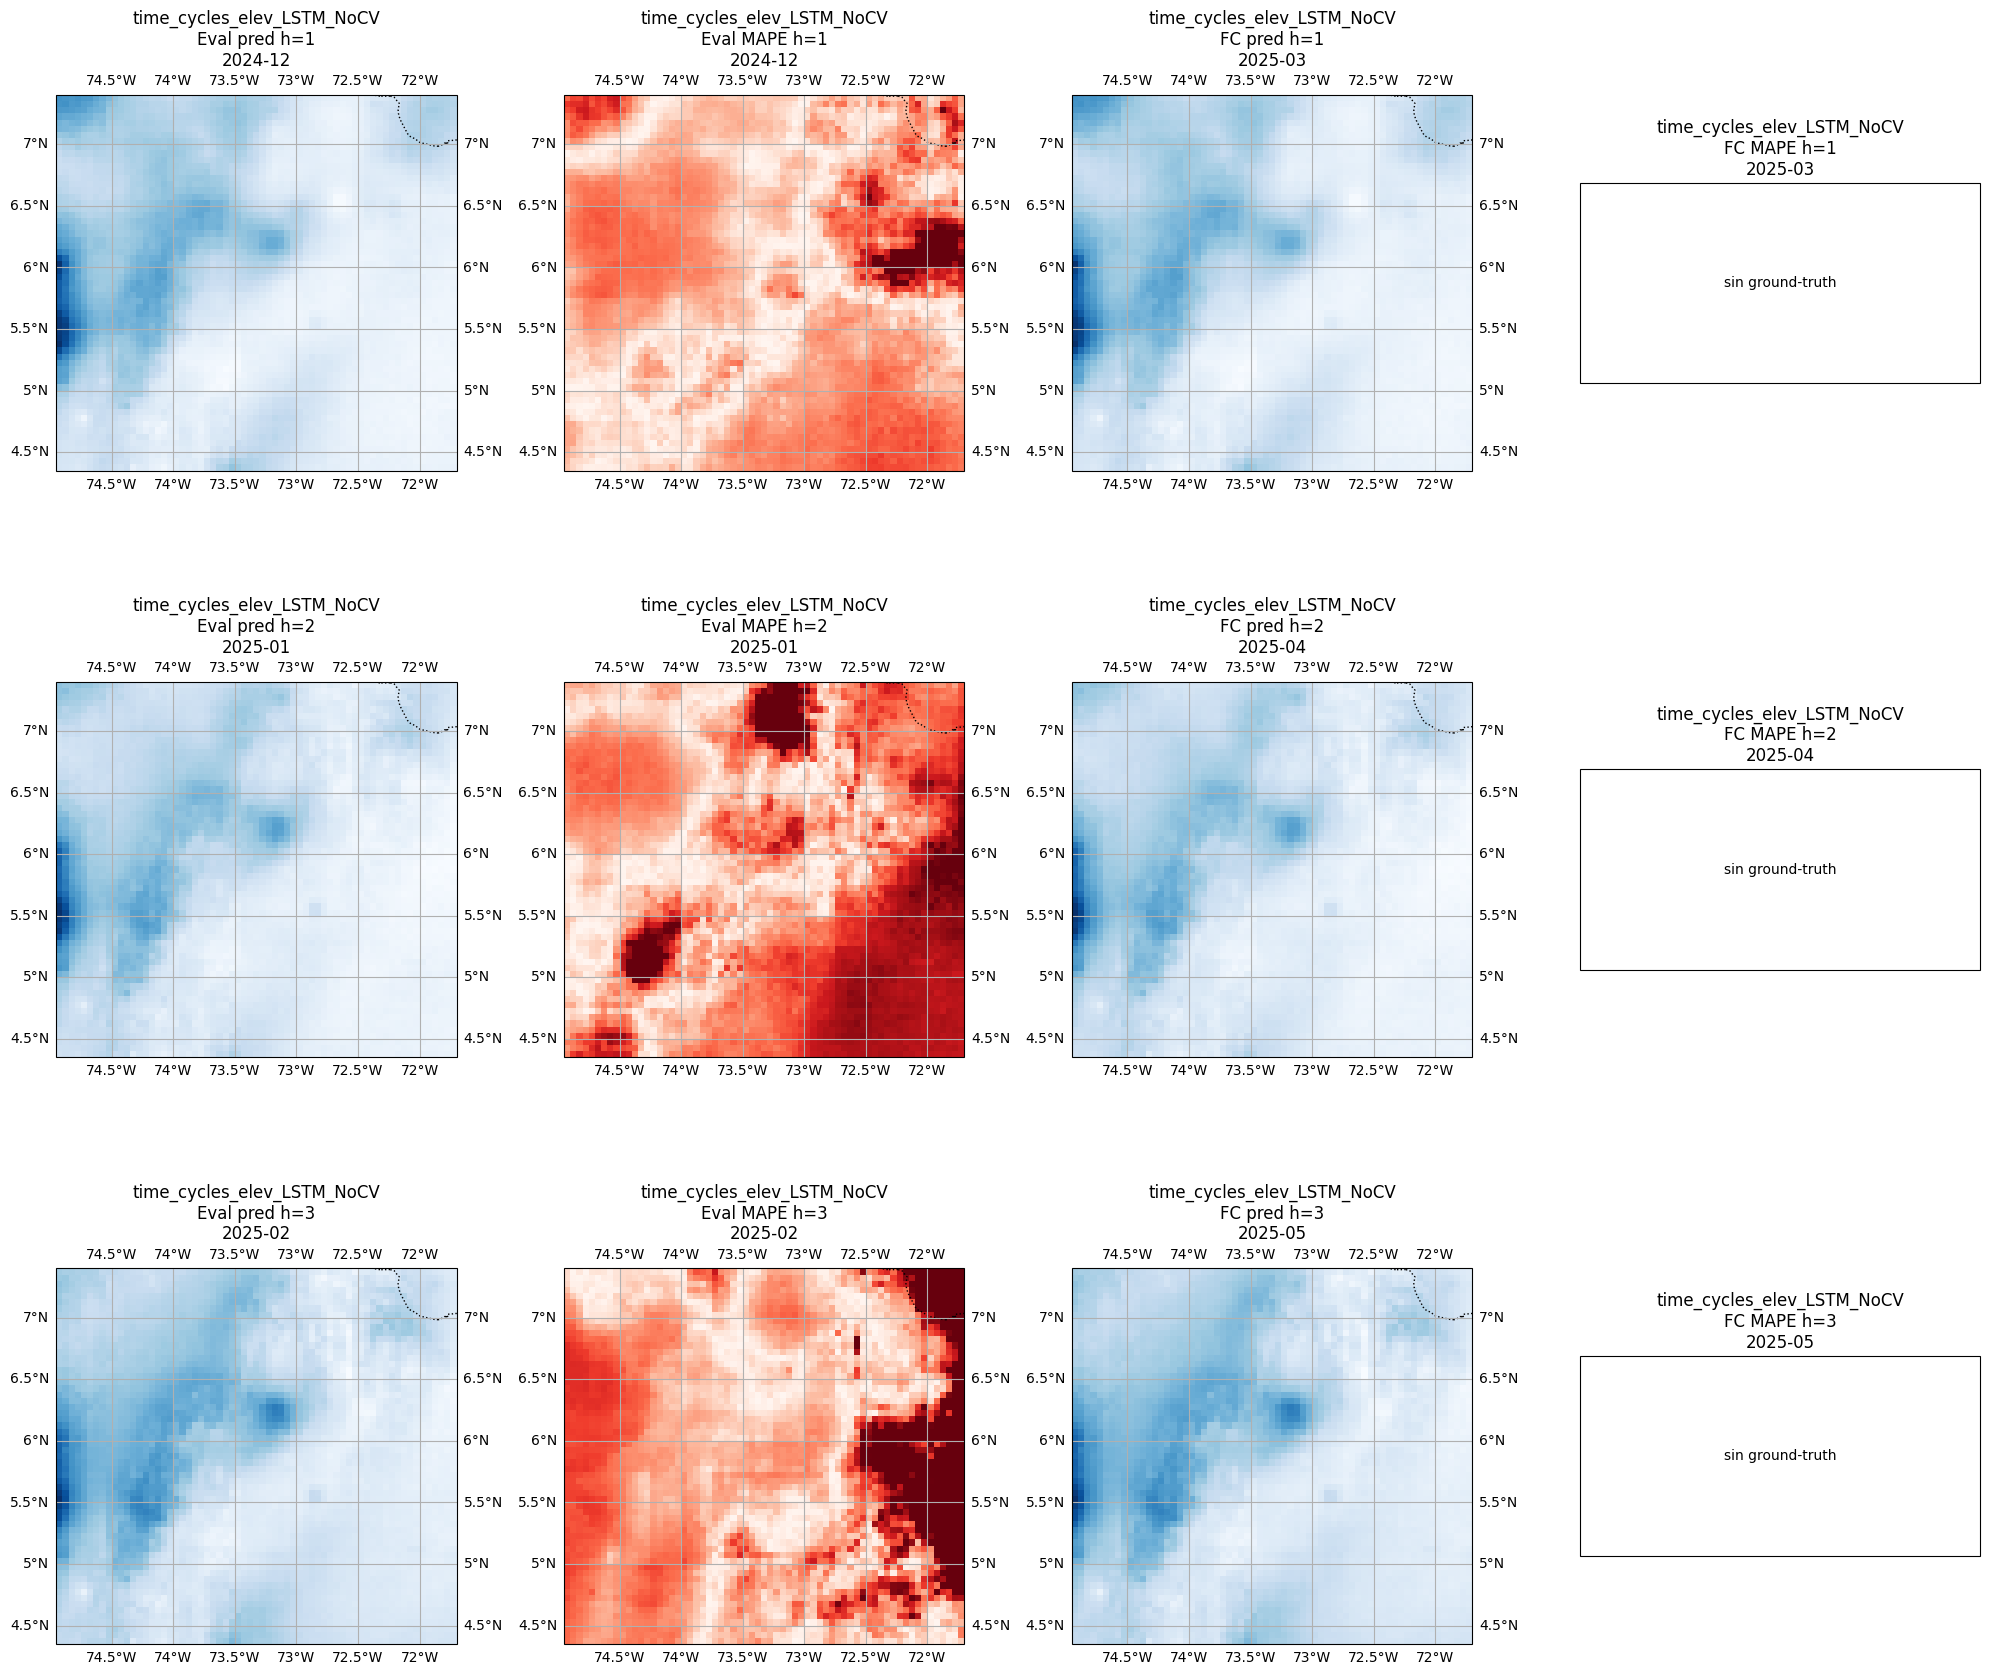


🔍 Evaluando modelo: time_cycles_elev_cluster_LSTM_NoCV


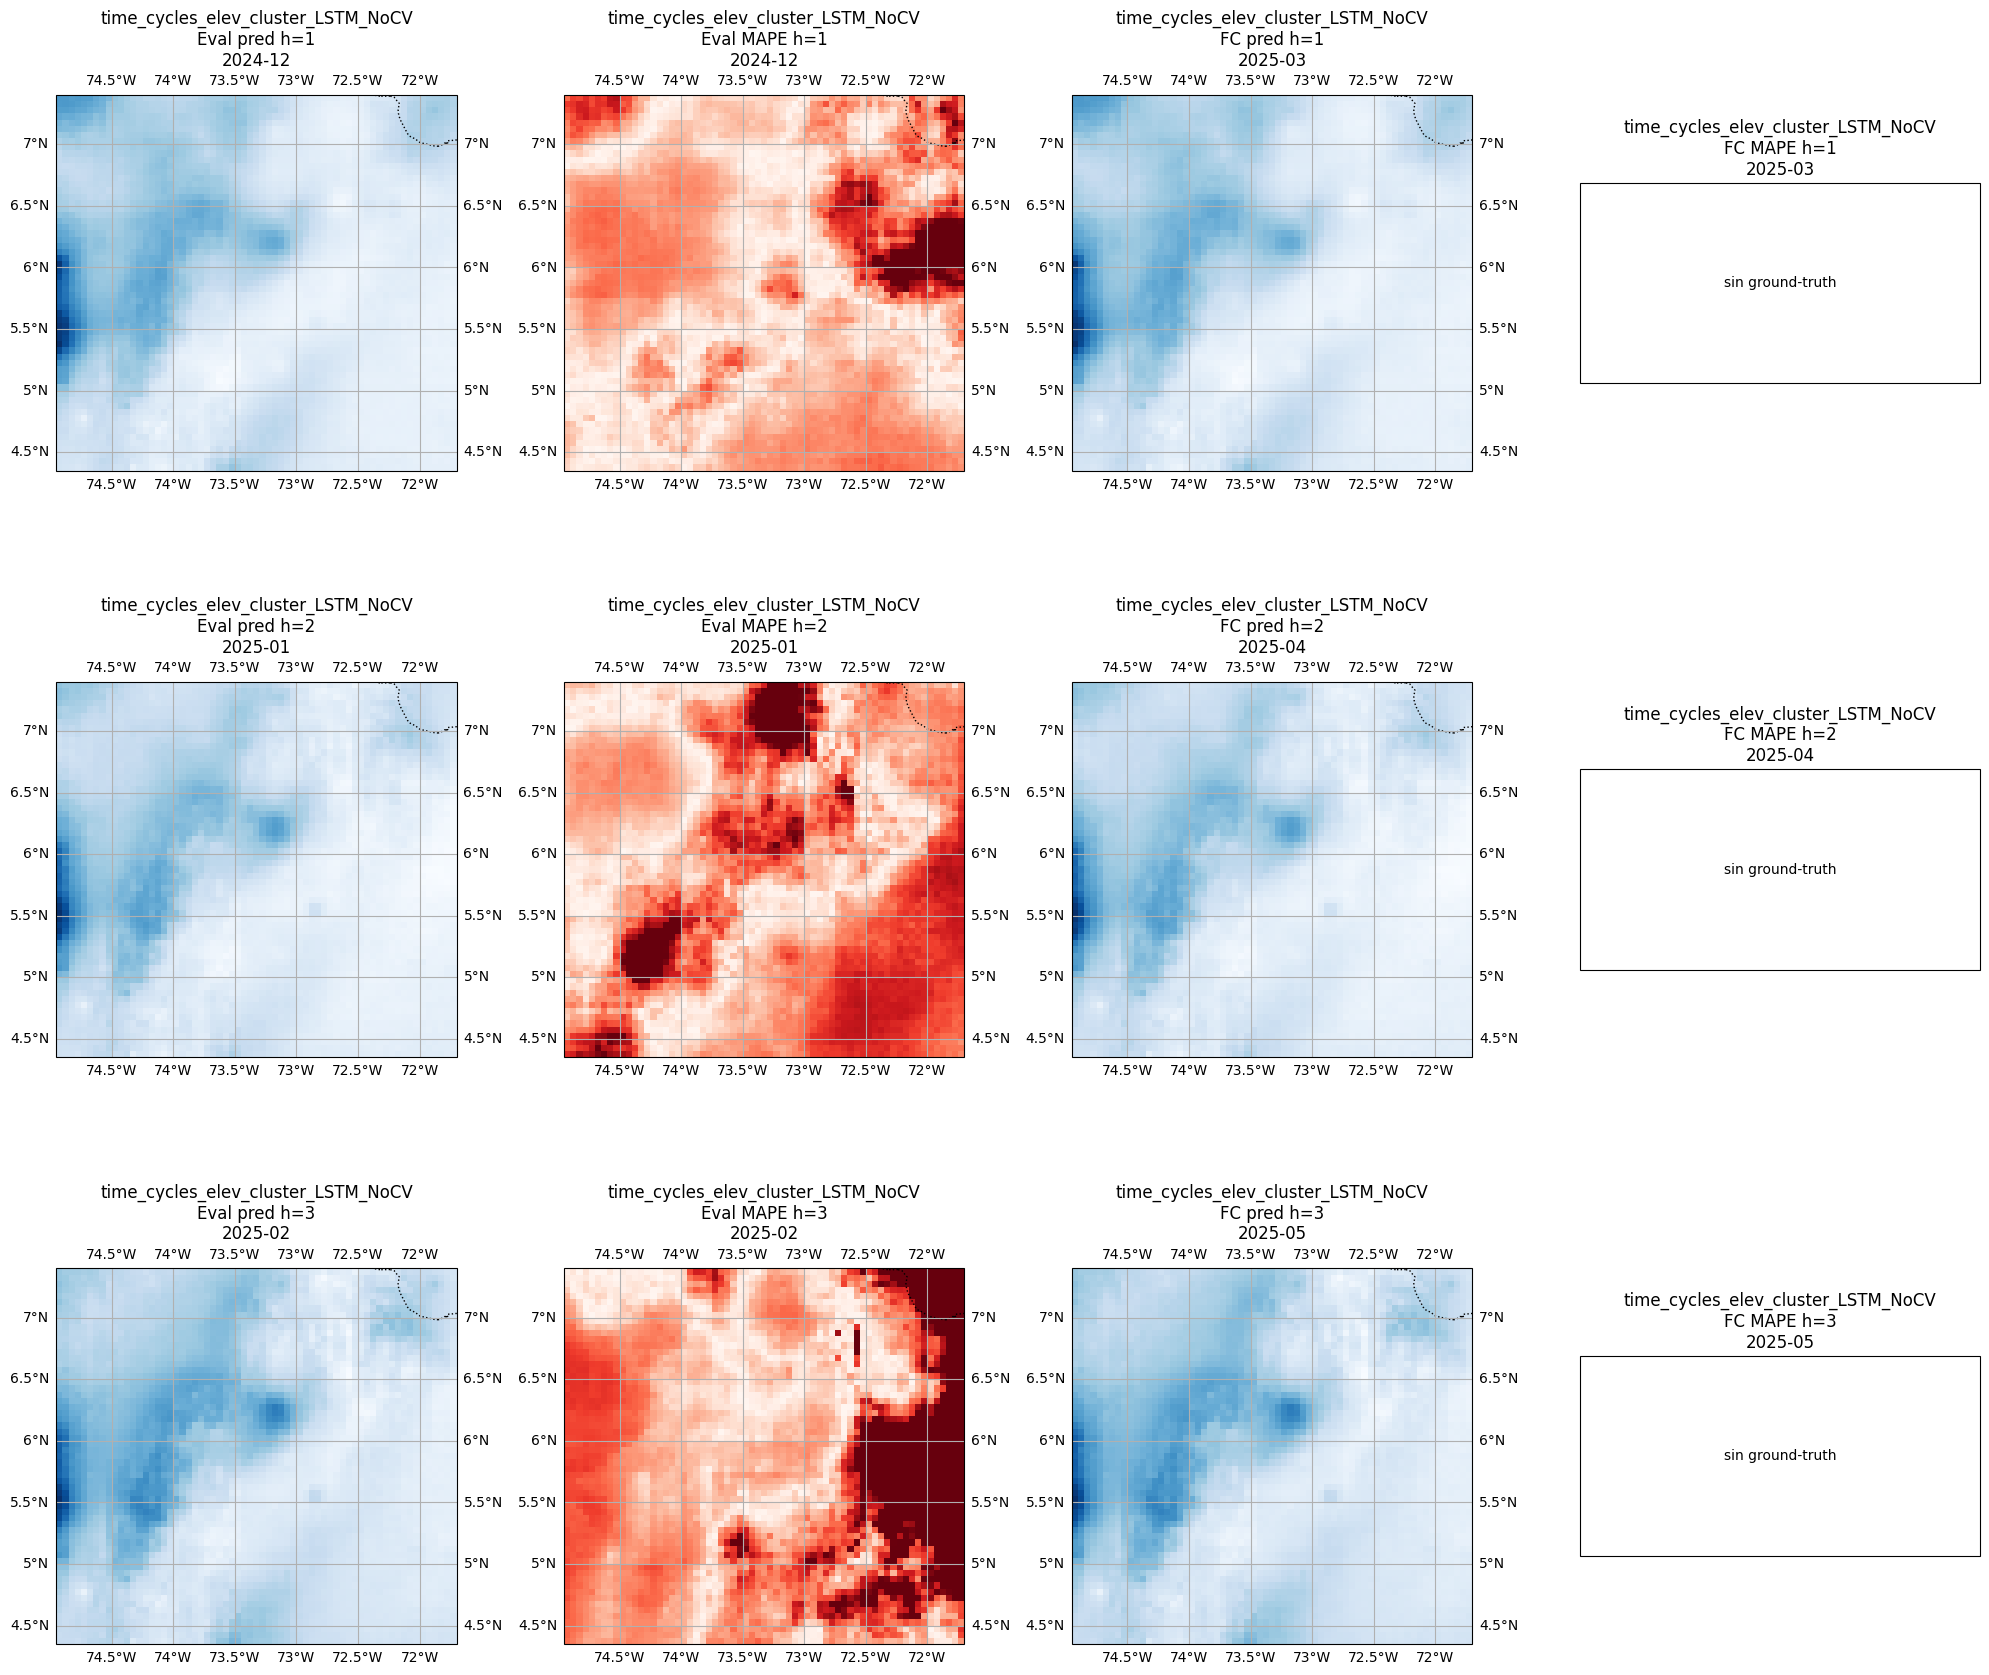


🔍 Evaluando modelo: time_cycles_lag_LSTM_NoCV


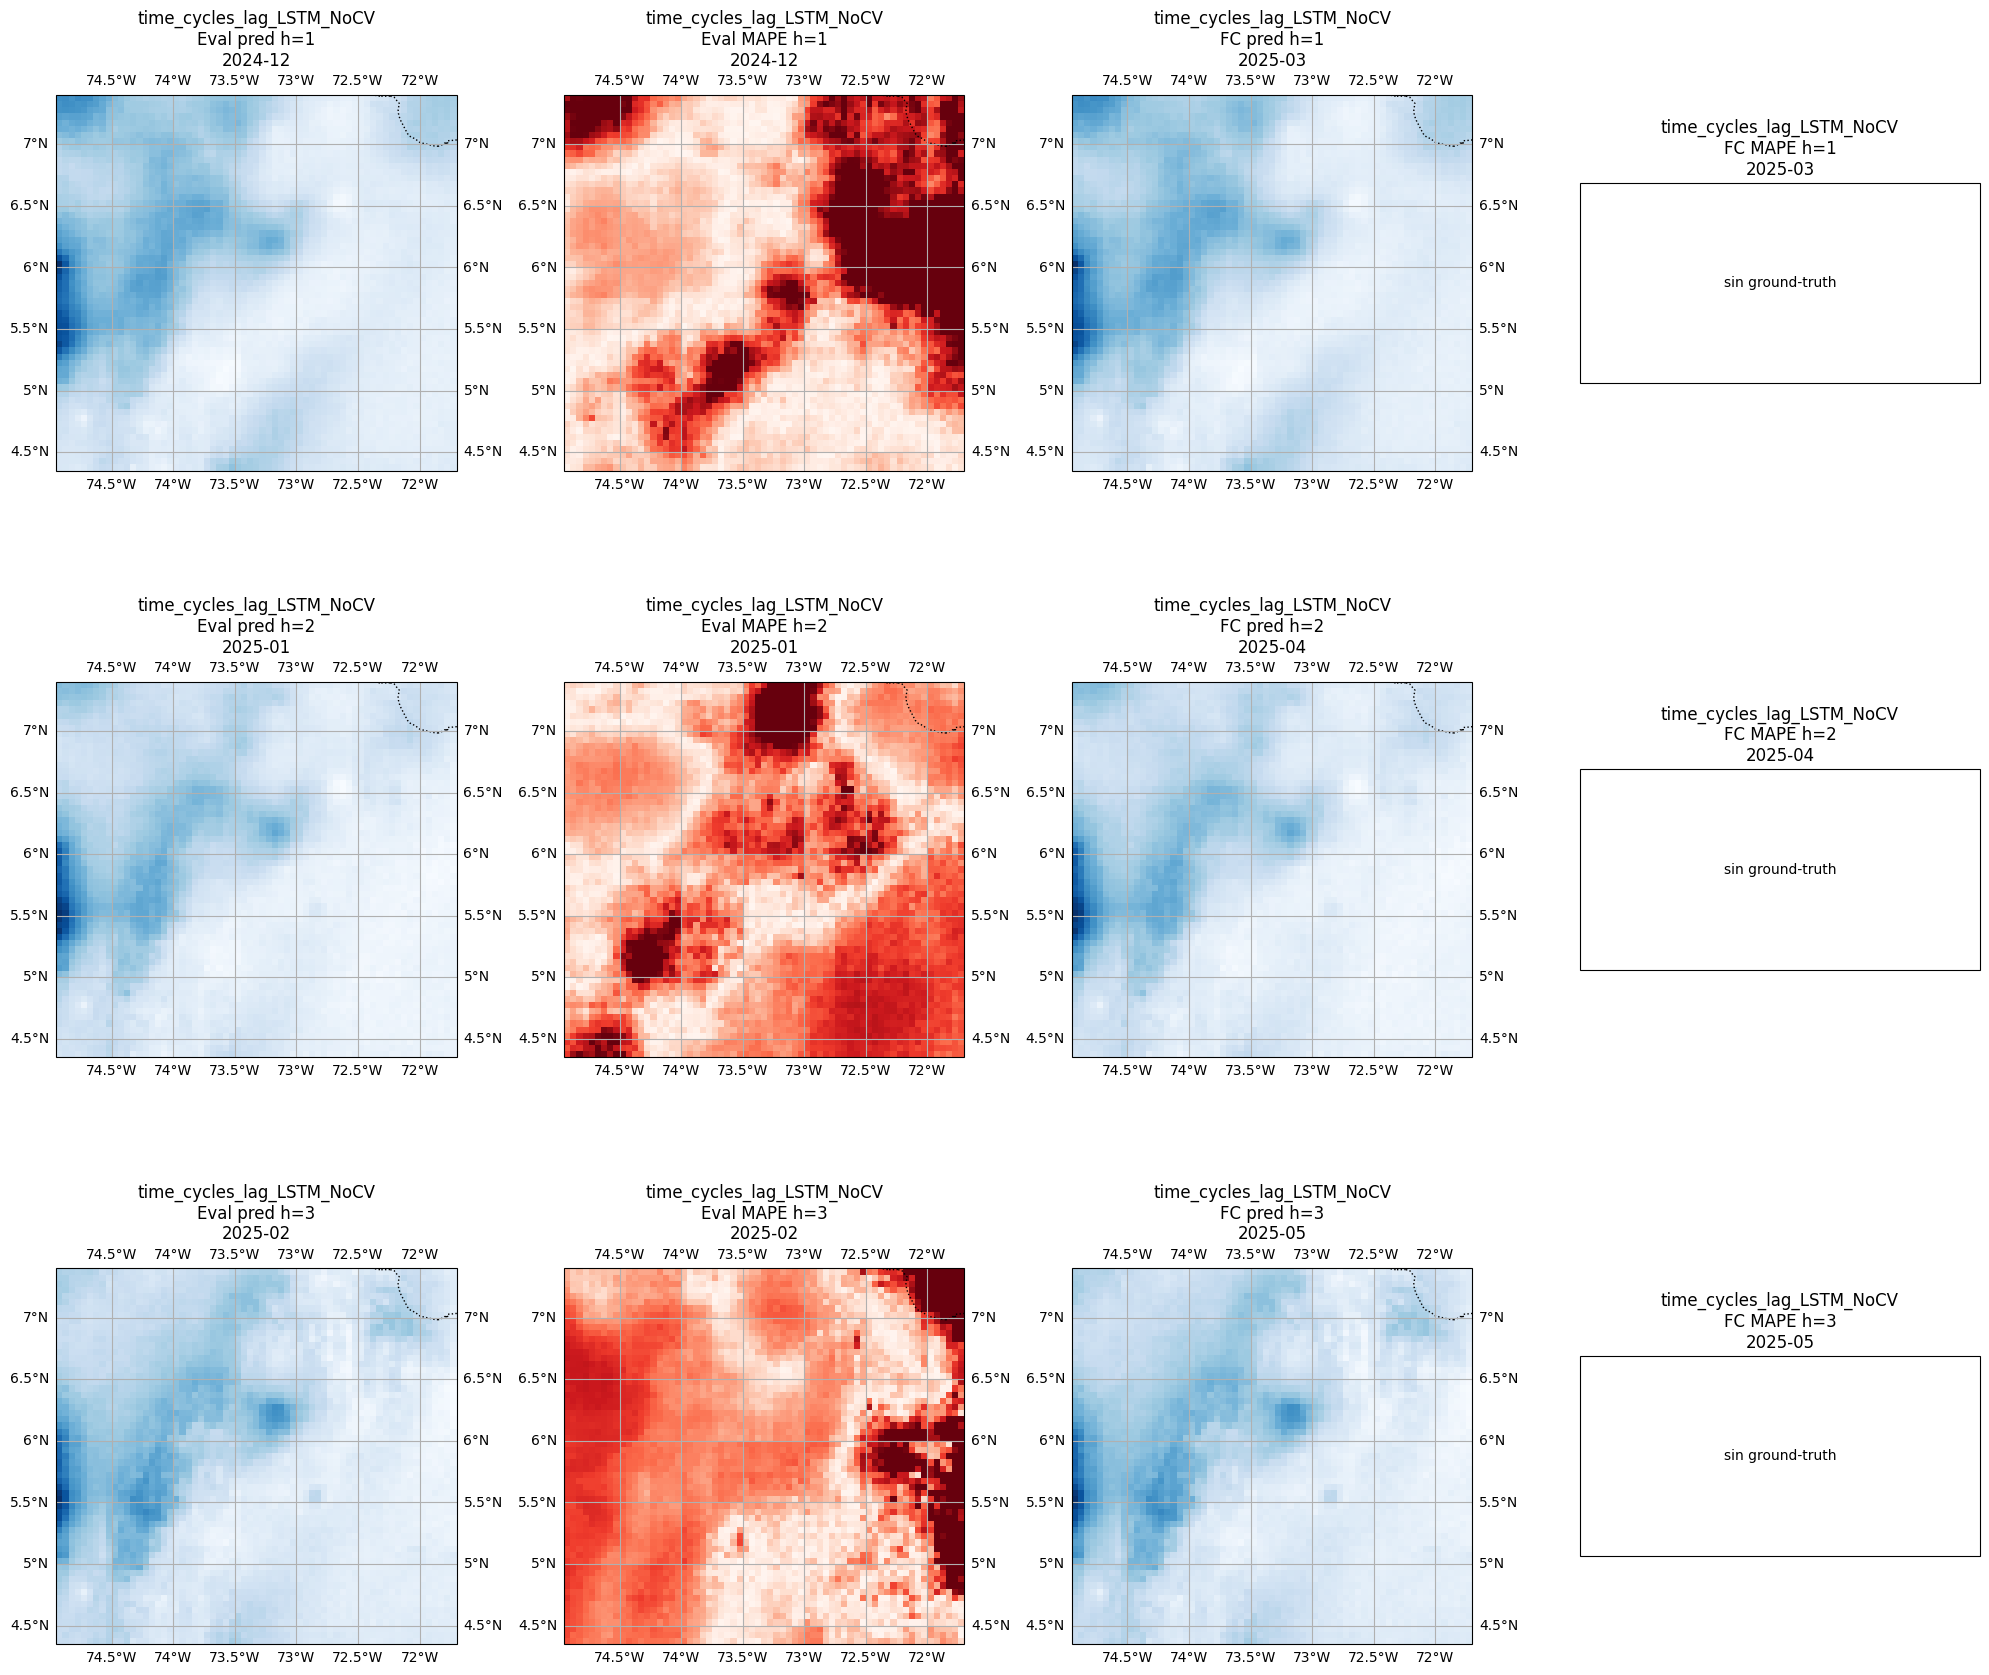

Resultados Dinámicos Eval & FC


✅ Proceso terminado exitosamente.


'\n\n---\n\n### ¿Qué hace esto?\n\n- **Carga** el netCDF y rellena NaNs con `0` (puedes cambiar estrategia).  \n- Genera todas las secuencias posibles `(N, 60, celdas, feats)`.  \n- **Toma sólo la última** para:\n  - **Evaluar** los 3 meses históricos posibles (últimos disponibles que el modelo puede reproducir).  \n  - **Pronosticar** los 3 meses posteriores al final de la serie.  \n- Escala globalmente con **todos** los datos de entrenamiento (cada experimento).  \n- Se adapta a **cualquier** número de variables / celdas (flat_dim), por lo que ya no habrá errores “espera X, obtuvo Y”.  \n- Plotea en un grid **ordenado** (HORIZON×4).  \n- Compila una **tabla** con RMSE/MAE/MAPE/R² para la fase de evaluación, y `NaN` para la fase de forecast.\n\nCon esta versión ya no verás errores de índices ni mismatch de dimensiones, y tendrás un workflow robusto para cualquier modelo o experimento.\n'

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import traceback

# === CONFIGURACIÓN GENERAL ===
INPUT_WINDOW    = 60
HORIZON         = 3
TARGET_VAR      = 'total_precipitation'
BASE_MODEL_DIR  = Path("/content/drive/MyDrive/ml_precipitation_prediction/models/output/ST_HybridWaveStack")
DATASET_PATH    = Path("/content/drive/MyDrive/ml_precipitation_prediction/data/output/complete_dataset_with_features_with_clusters_elevation_with_windows.nc")
RESULTS_CSV     = BASE_MODEL_DIR / "metrics_modelos_test_completo.csv"

# === MAPEO DE EXPERIMENTOS A VARIABLES ===
experiment_settings = {
    "time+cycles":             ['year','month','month_sin','month_cos','doy_sin','doy_cos'],
    "time+cycles+lag":         ['year','month','month_sin','month_cos','doy_sin','doy_cos',
                                'total_precipitation_lag1','total_precipitation_lag2','total_precipitation_lag3',
                                'total_precipitation_lag4','total_precipitation_lag12','total_precipitation_lag24','total_precipitation_lag36'],
    "time+cycles+elev":        ['year','month','month_sin','month_cos','doy_sin','doy_cos','elevation','slope','aspect'],
    "time+cycles+elev+cluster":['year','month','month_sin','month_cos','doy_sin','doy_cos',
                                'elevation','slope','aspect','cluster_elevation'],
    "all_features":            ['year','month','month_sin','month_cos','doy_sin','doy_cos',
                                'total_precipitation_lag1','total_precipitation_lag2','total_precipitation_lag3',
                                'total_precipitation_lag4','total_precipitation_lag12','total_precipitation_lag24','total_precipitation_lag36',
                                'elevation','slope','aspect','cluster_elevation']
}

# === CARGA DATASET Y PREPARA TIEMPOS ===
print("📂 Cargando dataset y rellenando NaNs…")
ds    = xr.open_dataset(DATASET_PATH).fillna(0)
times = pd.to_datetime(ds.time.values)
latitude, longitude = ds.latitude.values, ds.longitude.values
lat_size, lon_size = len(latitude), len(longitude)
n_cells = lat_size * lon_size

# === Función para subplot rápido ===
def quick_plot(ax, data, title, date_label, cmap, vmin=None, vmax=None):
    mesh = ax.pcolormesh(longitude, latitude, data,
                         cmap=cmap, shading='nearest',
                         vmin=vmin, vmax=vmax,
                         transform=ccrs.PlateCarree())
    ax.coastlines(); ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.gridlines(draw_labels=True)
    ax.set_title(f"{title}\n{date_label}")
    return mesh

# Orden de matching más largo primero (para evitar colisiones)
exp_keys = sorted(experiment_settings.keys(),
                  key=lambda k: len(k.replace('+','_')),
                  reverse=True)

# Acumulador de resultados
metrics = []

# ==== Bucle sobre modelos ====
for model_path in sorted(BASE_MODEL_DIR.glob("*.h5")):
    model_name = model_path.stem
    print(f"\n🔍 Evaluando modelo: {model_name}")

    # 1) Identificar experimento
    exp = next((k for k in exp_keys if k.replace('+','_') in model_name), None)
    if exp is None:
        print(f"⚠️ Experimento no reconocido para {model_name}. Se omite.")
        continue

    try:
        vars_ = experiment_settings[exp]

        # 2) Apilar X,y
        Xarr = ds[vars_].to_array().transpose("time","latitude","longitude","variable").values
        yarr = ds[TARGET_VAR].values
        # codificar cluster si aplica
        if 'cluster_elevation' in vars_:
            idx = vars_.index('cluster_elevation')
            le  = LabelEncoder()
            flat = Xarr[...,idx].ravel()
            Xarr[...,idx] = le.fit_transform(flat).reshape(Xarr[...,idx].shape)

        T, lat, lon, feats = Xarr.shape
        if T < INPUT_WINDOW + HORIZON + 1:
            raise RuntimeError("Pocos timestamps para esa ventana + horizonte.")

        # reshape espacial
        cells = lat*lon
        Xfull = Xarr.reshape(T, cells, feats)
        yfull = yarr.reshape(T, cells)

        # 3) Generar todas las secuencias válidas
        N = T - INPUT_WINDOW - HORIZON + 1
        Xs = np.stack([Xfull[i:i+INPUT_WINDOW] for i in range(N)], axis=0)
        ys = np.stack([yfull[i+INPUT_WINDOW:i+INPUT_WINDOW+HORIZON] for i in range(N)], axis=0)
        # Xs: (N, INPUT_WINDOW, cells, feats)
        # ys: (N, HORIZON, cells)

        # 4) Tomar la ÚLTIMA secuencia
        last = N - 1
        X_eval = Xs[last:last+1]   # (1,INPUT_WINDOW,cells,feats)
        y_eval = ys[last:last+1]   # (1,HORIZON,cells)
        X_fc   = X_eval            # misma entrada para forecast

        # 5) Fechas dinámicas
        base_idx    = last + INPUT_WINDOW
        eval_idx    = base_idx + np.arange(HORIZON)  # [T-HORIZON-1 ... T-2]
        eval_dates  = times[eval_idx]
        fc_dates    = pd.date_range(times[-1] + pd.offsets.MonthBegin(1),
                                    periods=HORIZON, freq="MS")

        # 6) Escaladores globales
        sx = StandardScaler().fit(Xs.reshape(-1, feats))
        sy = StandardScaler().fit(ys.reshape(-1, 1))

        # 7) Escalado de eval & forecast
        Xe_s = sx.transform(X_eval.reshape(-1, feats)).reshape(X_eval.shape)
        Xf_s = sx.transform(X_fc.reshape(-1, feats)).reshape(X_fc.shape)
        ye_s = sy.transform(y_eval.reshape(-1,1)).reshape(y_eval.shape)

        # 8) Aplanar dims para Keras: (batch, INPUT_WINDOW, cells*feats)
        flat_dim = cells * feats
        Xe_m = Xe_s.reshape(1, INPUT_WINDOW, flat_dim)
        Xf_m = Xf_s.reshape(1, INPUT_WINDOW, flat_dim)

        # 9) Cargar y chequear modelo
        model = tf.keras.models.load_model(model_path, compile=False)
        if model.input_shape[-1] != flat_dim:
            print(f"⚠️ Input mismatch: modelo espera {model.input_shape[-1]}, flat_dim={flat_dim}")
            continue

        # 10) Predecir
        ye_hat_s = model.predict(Xe_m, verbose=0)
        yf_hat_s = model.predict(Xf_m, verbose=0)

        # 11) Asegurar forma 3D: (1,HORIZON,flat_dim)
        def to3(a):
            if a.ndim==2:
                return a.reshape(1, HORIZON, flat_dim)
            return a
        ye_hat_s = to3(ye_hat_s)
        yf_hat_s = to3(yf_hat_s)

        # 12) Desescalar
        def inv(a3):
            flat = a3.reshape(-1,1)
            invf = sy.inverse_transform(flat).flatten()
            return invf.reshape(a3.shape)

        ye_hat = inv(ye_hat_s)[0]  # (HORIZON,cells)
        ye_true= y_eval[0]         # (HORIZON,cells)
        yf_hat = inv(yf_hat_s)[0]  # (HORIZON,cells)

        # 13) Dibujar subplots (HORIZON filas × 4 columnas)
        fig, axes = plt.subplots(HORIZON, 4, figsize=(20,6*HORIZON),
                                 subplot_kw={'projection':ccrs.PlateCarree()})
        for h in range(HORIZON):
            tmap = ye_true[h].reshape(lat,lon)
            pmap = ye_hat[h].reshape(lat,lon)
            mape = np.clip(np.abs((tmap-pmap)/(tmap+1e-5))*100, 0,100)
            fc   = yf_hat[h].reshape(lat,lon)

            quick_plot(axes[h,0], pmap, f"{model_name}\nEval pred h={h+1}", eval_dates[h].strftime("%Y-%m"), 'Blues')
            quick_plot(axes[h,1], mape, f"{model_name}\nEval MAPE h={h+1}", eval_dates[h].strftime("%Y-%m"), 'Reds', 0,100)
            quick_plot(axes[h,2], fc,   f"{model_name}\nFC pred h={h+1}", fc_dates[h].strftime("%Y-%m"), 'Blues')
            axes[h,3].text(0.5,0.5,"sin ground-truth", ha='center', va='center', transform=axes[h,3].transAxes)
            axes[h,3].set_title(f"{model_name}\nFC MAPE h={h+1}\n{fc_dates[h].strftime('%Y-%m')}")
        plt.tight_layout()
        plt.show()

        # 14) Calcular y acumular métricas
        for h in range(HORIZON):
            t = ye_true[h]
            p = ye_hat[h]
            m = np.clip(np.abs((t-p)/(t+1e-5))*100,0,100)
            rmse = np.sqrt(mean_squared_error(t,p))
            mae  = mean_absolute_error(t,p)
            mape = m.mean()
            r2   = r2_score(t,p) if not np.allclose(t,t[0]) else np.nan

            metrics.append({
                'model':      model_name,
                'experiment': exp,
                'horizon':    h+1,
                'type':       'evaluation',
                'date':       eval_dates[h].strftime("%Y-%m"),
                'RMSE':       rmse,
                'MAE':        mae,
                'MAPE':       mape,
                'R2':         r2
            })
            metrics.append({
                'model':      model_name,
                'experiment': exp,
                'horizon':    h+1,
                'type':       'forecast',
                'date':       fc_dates[h].strftime("%Y-%m"),
                'RMSE':       np.nan,
                'MAE':        np.nan,
                'MAPE':       np.nan,
                'R2':         np.nan
            })

    except Exception:
        print(f"❌ Error en {model_name}:\n{traceback.format_exc()}")

# === Guardar tabla y mostrar ===
df = pd.DataFrame(metrics)
df.to_csv(RESULTS_CSV, index=False)

import ace_tools_open as tools
tools.display_dataframe_to_user(name="Resultados Dinámicos Eval & FC", dataframe=df)

print("✅ Proceso terminado exitosamente.")

"""

---

### ¿Qué hace esto?

- **Carga** el netCDF y rellena NaNs con `0` (puedes cambiar estrategia).
- Genera todas las secuencias posibles `(N, 60, celdas, feats)`.
- **Toma sólo la última** para:
  - **Evaluar** los 3 meses históricos posibles (últimos disponibles que el modelo puede reproducir).
  - **Pronosticar** los 3 meses posteriores al final de la serie.
- Escala globalmente con **todos** los datos de entrenamiento (cada experimento).
- Se adapta a **cualquier** número de variables / celdas (flat_dim), por lo que ya no habrá errores “espera X, obtuvo Y”.
- Plotea en un grid **ordenado** (HORIZON×4).
- Compila una **tabla** con RMSE/MAE/MAPE/R² para la fase de evaluación, y `NaN` para la fase de forecast.

Con esta versión ya no verás errores de índices ni mismatch de dimensiones, y tendrás un workflow robusto para cualquier modelo o experimento.
"""